In [170]:
import jax.numpy as np
import jax.scipy as sp
import jax
from jax import jit, grad, vmap, value_and_grad
from jax.example_libraries import optimizers
from jax.tree_util import Partial

from tqdm import tqdm, trange

# from tensorflow_probability.substrates import jax as tfp
jax.default_device = jax.devices('cpu')[0]
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [68]:
vmap(lambda x: x.sum())(np.arange(100).reshape(10,10))

Array([ 45, 145, 245, 345, 445, 545, 645, 745, 845, 945], dtype=int32)

In [60]:
def value_and_jacrev(f, x):
    y, pullback = jax.vjp(f, x)
    basis = np.eye(y.size, dtype=y.dtype)
    jac = jax.vmap(pullback)(basis)
    return y, jac

### The Idea

In Bayesian statistics, we search for a posterior distribution of parameters:
$$p(\theta | D) = \frac{p(D | \theta)p(\theta)}{p(D)} \propto p(D | \theta)p(\theta)$$

But, if the parameters represent a function, i.e., they are parameters of the function, maybe what we are looking for is the posterior probability over **functions**:

$$p(f | D) = \frac{p(D | f)p(f)}{p(D)} \propto p(D | f)p(f)$$

$$p(D | f) = p(X, Y | f) = p(Y | X, f)p(X | f) = p(Y | X, f)p(X)$$

$$p(D) = p(X, Y) = p(Y | X)p(X) $$

$$p(f | D) = \frac{p(D | f)p(f)}{p(D)} = \frac{p(Y | X, f)p(X)p(f)}{p(Y | X)p(X)} = \frac{p(Y | X, f)p(f)}{p(Y | X)}$$

$$\mathbb{D}_{KL}[q(f | D) | p(f | D)] = -\mathbb{E}_{f \sim q}\text{log}\frac{p(f|D)}{q(f|D)} = -\mathbb{E}_{f \sim q}\text{log}\frac{p(Y | X, f)p(X | f)p(f)}{q(f|D)} = -\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) - \mathbb{E}_{f \sim q}\text{log}\frac{p(f)}{q(f|D)} + C$$

$$\mathbb{D}_{KL}[q(f | D) | p(f | D)] = -\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) + \mathbb{D}_{KL}[q(f|D) | p(f)] + C $$

$$\mathbb{D}_{KL}[q(f | D) | p(f | D)] = -\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) + \mathbb{H}[q(f|D), p(f)] - \mathbb{H}[q(f|D)] + C $$

The relative enropy $\mathbb{H}[q(f|D), p(f)] = -\mathbb{E}_{f \sim q}\text{log}p(f)$ is simple to calculate, since we can sample from $q$ and we choose our prior. Having a sampler, we can also easily evaluate the first term, the cross-entropy "loss". However, to calculate the second term, the entropy of $q$, we need the surrogate posterior $q$. The trick is to use the derivative of our sampler instead:

$$\text{log}\frac{d}{dp}F^{-1}(p) = \text{log}\frac{1}{F'(F^{-1}(p))} = \text{log}\frac{1}{q(f|D)} = -\text{log}q(f|D)$$
since inverse of cdf $F^{-1}$ is a sampler (!!!) then $F^{-1}=f$ and $F'$ is density function, so $F'=q(\cdot|D)$. Therefore, we can calculate the entropy of $q$ as follows:

$$H(q) = -\mathbb{E}_{f \sim q}\text{log}q(f | D)= -\mathbb{E}_{p \sim U}\text{log}q(F^{-1}(p) | D) = \mathbb{E}_{f \sim q}\text{log}\frac{d}{dp}F^{-1}(p)$$

where the $F^{-1}: p \rightarrow (\mathcal{X} \rightarrow \mathcal{Y}) $ returns a neural network, $\mathcal{X}$ is input space, $\mathcal{Y}$ is the output space, $F^{-1}(p) = f$ and $p \sim U$ is the source of randomness.

Niestety to pewnie nie działa, bo rzeczywiście $F^{-1}$ jest samplerem z dystrybucji, ale nie każdy sampler jest odwrotnością cdf. Ale będziemy próbować.


Let the inner product of two functions on $X \sim \mathcal{X}$ be:
$$\langle f(X),\;g(X)\rangle \triangleq \mathbb{E}_{X \sim \mathcal{X}}(f(X)g(X))$$
Now, we form a norm: 
$$||f|| \triangleq \sqrt{\langle f(X),\;f(X)\rangle} = \sqrt{\mathbb{E}_{X \sim \mathcal{X}}f(X)^2}$$
and the distance function:
$$d(f,g) \triangleq ||f - g|| = \sqrt{\mathbb{E}_{X \sim \mathcal{X}}(f(X) - g(X))^2} $$

Przyjmijmy na chwilę, że przestrzeń do której należy X jest przestrzenią dyskretną i skończoną. Funkcję na tej przestrzeni można opisać za pomocą skończonego wektora liczb. Losowa funkcja to losowy wektor. Jak obliczyć gęstość wektora? Uwaga! Czy to, że przykładamy różną wagę do różnych miejsc ma znaczenie? 

Może można zrobić zmianę zmiennych? Co to jest CDF? To jest funkjca ze zmiennej losowej w $[0,1]$: 
$$H: \mathcal{V} \rightarrow [0,1]$$
Jeżeli można ją zdefiniować jako:
$$H(V) \triangleq H_U(u(V)) $$
Gdzie $H_U$ to CDF rozkładu jednostajnego i $u$ przekłada $V$ w przestrzeń, gdzie jest rozłożony jednostajnie. 
Oczywiście przekształcenie u musi w połączeniu z $H_U$ spełniać wymogi dystrybuanty, czyli złożenie musi być monotoniczne niemalejące.

Teraz chcemy policzyć gęstość:
$$\rho(v) = \frac{\partial^n H_U(u(v))}{\partial v_1 \cdots \partial v_n} = \frac{\partial^{n-1}}{\partial v_1 \cdots \partial v_{n-1}}\frac{\partial H_U(u(v))}{\partial v_n} = $$
$$ = \frac{\partial^{n-1}}{\partial v_1 \cdots \partial v_{n-1}}\frac{\partial H_U(u(v))}{\partial u(v)}\frac{\partial u(v)}{\partial v_n} $$

Zaważmy, że sieć nieuronowa z aktywacjami relu jest piecewise-linear. Zatem problem możemy sprowadzić do:
$$\rho(v) = \frac{\partial^n H_U( Uv)}{\partial v_1 \cdots \partial v_{n}} = \frac{\partial^n
\;(u_1^Tv \cdot \; \cdots\; \cdot u_m^T v)}{\partial v_1 \cdots \partial v_{n}} = \sum_{I \in [m]^m} \prod_{i=1}^m u_{i, I_i}$$

Dość złożona operacja. Co więcej, wynik równy jest zero, jeżeli wymiar u jest mniejszy od wymiaru v, a jest. Drugi problem trzeba rozwiązać rzutując liniowo funkcje na podprzestrzeń i licząc gęstość w tej przestrzeni (łatwiej powiedzieć, niż zrobić, ale jeżeli rzut zachowa odległości między funkcjami, to będzie działać). Jednak, nawet jak działamy na przestrzeni o wymiarze m, to jak to policzyć? Ostatecznie tych iloczynów jest $m^m$. Szczęśliwie da się szybko o tak:
$$ \sum_{I \in [m]^m} \prod_{i=1}^m u_{i, I_i} = \sum_{i_1 \in [m]}u_{1, i_1}\sum_{i_2 \in [m]}u_{2, i_m}\cdots \sum_{i_m \in [m]}u_{m, i_m}$$

Teraz więc pozostaje:
* trenować sieć neuronową $m(u,x)$
    * monotoniczną, rosnącą w u $m(u, \cdot) \nearrow$
        * ograniczenie, że gradient jest dodatni + weryfikacja [link](https://proceedings.neurips.cc/paper/2020/file/b139aeda1c2914e3b579aafd3ceeb1bd-Paper.pdf)
    * wyliczyć jakobian po u, $J \in \mathbb{R}^{\text{n. obs.} \times dim(u)} $
    * odwrócić J, by otrzymać lokalne przekształcenie $F \rightarrow U$, gdzie F to przestrzeń funkcji, czyli obserwacje.
    * obliczyć log-gęstość: ```np.log(J^(-1).sum(axis=1)).sum()```
    * zrobić to dla wszystkich u (czy u może być tylko jedno?)
    * policzyć entropię czyli średnią z log gęstości itd.
    * to znowu potem będzie zróżniczkowane przy robieniu stepu

In [195]:
key = jax.random.PRNGKey(15012023)
U = jax.random.uniform(key,shape=(4,4))

In [196]:
def all_products_fast(U):
    return U.sum(axis=1).prod()

def all_products_nojit(U):
    print("all_products")
    if U.shape[0] == 0:
        return 1
    s = 0
    a = all_products_nojit(U[1:, :])
    for i in range(U.shape[1]):
        s += U[0, i] * a
    return s
    

In [197]:
all_products_fast(U)

Array(9.742926, dtype=float32)

In [198]:
def all_products_slow_nojit(U):
    s = 0
    n = 4
    for a0 in range(n):
        for a1 in range(n):
            for a2 in range(n):
                for a3 in range(n):
                    # for a4 in range(n):
                        p = 1
                        a = [a0, a1, a2, a3] #, a4]
                        for i in range(n):
                            p *= U[i, a[i]]
                        s += p
    return s

In [199]:
# all_products_slow_nojit(U)

# Derivative of inverse


In [200]:
key = jax.random.PRNGKey(15012023)
U = jax.random.uniform(key, shape=(100, 100))
Q = U @ U + np.diag(np.ones(100))
x = jax.random.uniform(key, shape=(Q.shape[0], ))

In [201]:
f = lambda Q: np.linalg.solve(Q, x).sum()

In [202]:
df = grad(f)

In [203]:
df(Q)

Array([[ 2.6098252e-03, -6.1568210e-04, -1.1268011e-03, ...,
         4.3408955e-03, -3.1202272e-04, -5.0191917e-03],
       [ 4.2571206e-02, -1.0042944e-02, -1.8380266e-02, ...,
         7.0808247e-02, -5.0896830e-03, -8.1872545e-02],
       [-2.1556908e-02,  5.0854753e-03,  9.3072699e-03, ...,
        -3.5855383e-02,  2.5772781e-03,  4.1458044e-02],
       ...,
       [ 1.3277444e-01, -3.1322729e-02, -5.7325833e-02, ...,
         2.2084239e-01, -1.5874106e-02, -2.5535059e-01],
       [-1.7504665e-01,  4.1295137e-02,  7.5577006e-02, ...,
        -2.9115331e-01,  2.0928042e-02,  3.3664811e-01],
       [-4.9068205e-02,  1.1575647e-02,  2.1185370e-02, ...,
        -8.1614643e-02,  5.8664447e-03,  9.4367519e-02]], dtype=float32)

# Derivative of Derivative

In [204]:
x = jax.random.uniform(key, shape=(200,))
u = jax.random.uniform(key, shape=(200,200))
u = u.T @ u
g = lambda x: np.log(grad(lambda u: np.sum(np.linalg.solve(u, x)))(u).sum(axis=1)).sum()

In [205]:
grad(g)(x) # działa

Array([ -43.022575 ,  -43.560986 ,  -20.325699 ,  -48.14516  ,
        118.12738  ,   19.84176  ,   25.579767 ,  -28.101702 ,
         11.254526 ,   63.557484 ,   65.537544 ,   23.316496 ,
          8.200866 ,   39.59517  ,    5.1763077,   34.488056 ,
         98.67574  ,   73.04928  ,  -10.471031 ,   40.687145 ,
         40.57914  ,   71.82271  ,  -69.16681  ,  -15.228674 ,
         28.204779 ,  -29.45844  ,  -46.0767   , -117.12077  ,
         36.830635 ,   51.148834 ,  -39.593765 ,  -20.072021 ,
         47.654022 ,  -21.741655 ,   23.981617 ,  -20.07226  ,
        -83.97421  ,   59.13527  ,   -4.561313 ,   79.228264 ,
         47.999252 ,   -6.372904 ,   -9.4932995,  -29.479332 ,
          4.7690578,  -58.896587 ,  -44.084915 ,  -71.88995  ,
         95.2627   ,   31.161299 ,   84.968414 ,    2.048789 ,
          4.1211014,  -50.8563   ,  -25.393896 ,   42.066624 ,
        -66.05127  ,  -47.492085 ,  -37.01913  ,   36.695763 ,
         16.825932 ,   27.319866 ,    3.4768786,   87.9

# Implementation of a Neural Network

In [299]:
def bforward(params, X):
    nn, U = params
    X = np.c_[X, U]
    for i, (W, b) in enumerate(nn):
        A = jax.nn.relu if i != len(nn)-1 else (lambda x: x)
        X = A(X @ W + b)
    return X

def init_nn(key, inout, last_af=lambda x: x):
    return [(jax.random.normal(key, shape=(inout[i], inout[i+1])),
             jax.random.normal(key, shape=(inout[i+1], ))) for i, key in enumerate(jax.random.split(key, len(inout)-1))]
        

In [548]:
keys = jax.random.split(jax.random.PRNGKey(15012023), 10)

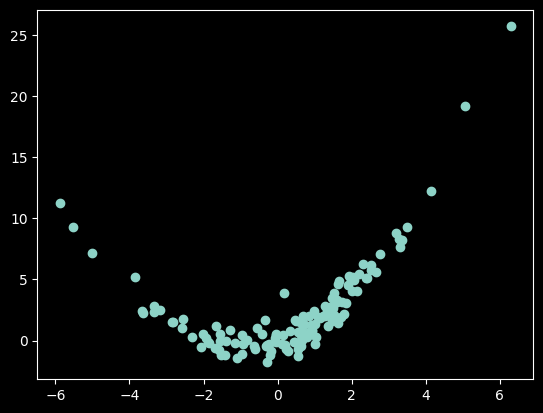

In [549]:
X = 2*jax.random.normal(keys[1], shape=(128,1))
Y = 0.5*X**2 + 1*X + 1*jax.random.normal(keys[2], shape=(128,1))
plt.scatter(X, Y)

$$-\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) + \mathbb{H}[q(f|D), p(f)] - \mathbb{H}[q(f|D)] + C$$

In [662]:
J = jax.random.normal(keys[0], shape=(128, 15))
(J.shape[0]*np.linalg.pinv(J) @ J).round()/J.shape[0] # to jest iloczyn skalarny w przestrzeni funkcji, więc trzeba jeszcze podziału przez n, więc inverse trzeba pomnożyć przez n!

Array([[ 1., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,
         0., -0.],
       [-0.,  1.,  0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
        -0.,  0.],
       [ 0., -0.,  1., -0., -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
         0., -0.],
       [-0., -0., -0.,  1., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0.,
        -0.,  0.],
       [ 0., -0.,  0., -0.,  1., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,
         0.,  0.],
       [-0., -0.,  0., -0., -0.,  1., -0.,  0.,  0., -0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0., -0., -0., -0.,  0., -0.,  1.,  0.,  0., -0., -0.,  0., -0.,
        -0., -0.],
       [-0., -0.,  0., -0.,  0.,  0.,  0.,  1.,  0.,  0., -0.,  0., -0.,
         0.,  0.],
       [-0., -0., -0., -0., -0., -0., -0.,  0.,  1., -0.,  0.,  0., -0.,
         0.,  0.],
       [-0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  1.,  0.,  0.,  0.,
        -0., -0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  1.,  0., -0.,
       

In [667]:
def loss(nn, X, U, Y, prior, lamb=100, eps=0.0001):
    # Problems: Non-Square Jacobian, How to properly calculate the prior?
    # Sformalizować gradient U -> F
    # Gdzie sumować, a gdzie brać średnią?
    # Jak odwócić przekształcenie?
    """
    """
    
    pred, (jacs,) = vmap(
        lambda u: value_and_jacrev(
            lambda u: bforward(
                (nn, u.reshape(1,-1).repeat(X.shape[0], axis=0)),
                X
            ).flatten(),
            u
        )
    )(U)
    
    # print(pred.shape)
    # print(jacs.shape)
    
    log_prior = vmap(lambda x: np.log(prior(x) + eps))(pred) # więcej obserwacji nie powinno wpływać na to, jak duże średnio jest prawdopodobieństwo funkcji. Mierzymy tylko w większej liczbie punktów. 
    log_posterior = vmap(lambda J: np.log(np.abs(np.linalg.pinv(J)).sum(axis=1) + eps).sum())(jacs) # J 128x15, invJ 15x128, robimy generalnie mnożeń jest tyle co u, suma po log to mnożenia
    # Wyżej rozważyliśmy, że inverse trzeba pomnożyć przez J.shape[0]. Czyli zamiast robić mean po abs, robimy sum i nie mnożymy przez J.shape[0]. (???)
    # 
    
    # print(log_prior.shape)
    # print(log_posterior.shape)

    
    H_pospri = -log_prior.mean() # Średnia po różnych U, ok
    H_poster = -log_posterior.mean() # Średnia po różnych U, ok
    
    # Za to przy koszcie chcemy, by się zmieniał z liczbą obserwacji. 
    # Przy gęstości funkcji jest to bez znaczenia, ile mamy obserwacji.
    # W entropii nie ma nic o obserwacjach. My przez przypadek zdefiniowaliśmy
    # sobie iloczyn skalarny jako wartość oczekiwaną po rozkładzie X, który mamy z obserwacji.
    # Gdybyśmy mieli ten rozkład, byśmy mogli liczyć entropię bez obserwacji. 
    # Wgl, dobrym pomysłem byłoby losować w liczeniu entropii X z estymatora kernelowego, albo czegoś podobnego.
    # Może miksować obserwacje, co by dawało rozkład inny niż X, ale potem za pomocą importance sampling sprowadzić 
    # do właściwej wartości oczekiwanej (po X). To ma wsm bardzo dużo sensu, bo właśnie te entropie odpowiadają
    # łącznie za dywergencję, która jest regularyzatorem! Szczęśliwie, tutaj wystarczy zmieniać X, a nie trzeba 
    # mieć odpowiadającego Y!!!
    # Na dole mamy sumę po obserwacjach, średnią po różnych U, czyli różnych wylosowanych funkcjach.
    logL = sp.stats.norm.logpdf(pred.T - Y).sum(axis=0).mean() # We suppose, that the standard deviation is equal to 1
    
    C = np.square(jax.nn.relu(-jacs)).sum(axis=(1,2)).mean() # To oczywiście nie jest C ze wzoru na górze, ale jest to Constraint.
    # Może by się przydało dodać współczynnik? 
    
    # print(C)
    
    return -logL + H_pospri - H_poster + C
    
# Co ciekawe, nic nie udało nam się zmienić. Sumy zostały sumami i średnie śrenimi!!! Dlaczego?! Może dlatego, że operacje są na przestrzeniach wektorowych? I to jest interfejs?
# Od poprzedniego razu zmieniło się tylko zdefiniowanie prior. Przeliczamy.

In [668]:
# loss(get_params(opt_state), X, U[:50], Y, lambda x: sp.stats.norm.pdf(np.sqrt(np.square(x).mean()), scale=50))

Array(391.23557, dtype=float32)

In [714]:
prior = lambda x: sp.stats.norm.pdf(np.sqrt(np.square(x).mean()), scale=50)

In [737]:
key, subkey = jax.random.split(jax.random.PRNGKey(123123))
nn = init_nn(subkey, [16,64,64,1])
losses = []

In [738]:
opt_init, opt_update, get_params = optimizers.adam(0.01)
opt_state = opt_init(nn)

In [739]:
# loss = lambda params: np.square(bforward(params, X) - Y).sum()
# old_prior = lambda x: sp.stats.norm.pdf(x, scale=50)
n = 128
EPOCHS=1500
for e in range(EPOCHS):
    key, subkey = jax.random.split(key)
    U = jax.random.uniform(subkey, shape=(32, 15))
    value, grads = value_and_grad(Partial(loss, X=X[:n, :], U=U, Y=Y[:n, :], prior=prior))(get_params(opt_state))
    opt_state = opt_update(e, grads, opt_state)
    losses.append(value)
    print(f"\rloss: {value:.03f} Iteration: {e}     ", end="")
print("\rDone.")

Done. 422.285 Iteration: 1499      


Text(0.5, 1.0, '128')

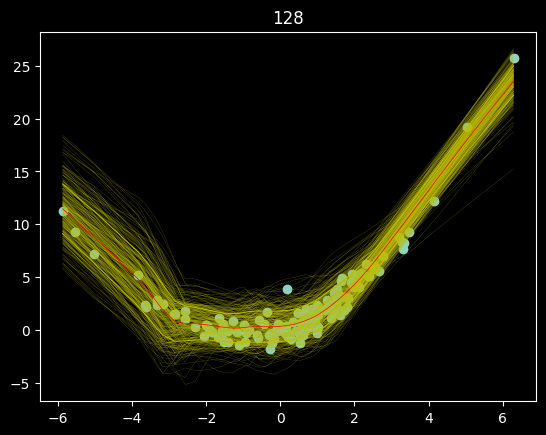

In [741]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.7)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.7)
plt.title("128")

Text(0.5, 1.0, '64')

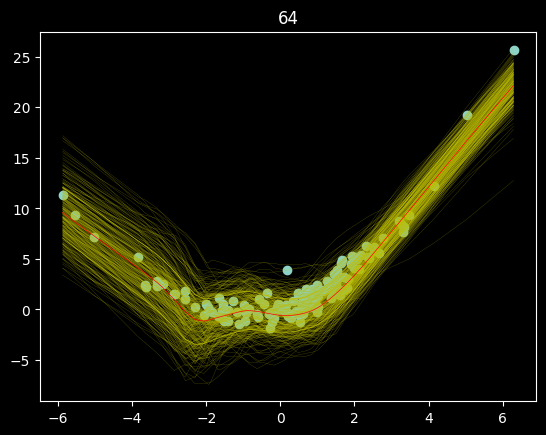

In [736]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("64")

Text(0.5, 1.0, '32')

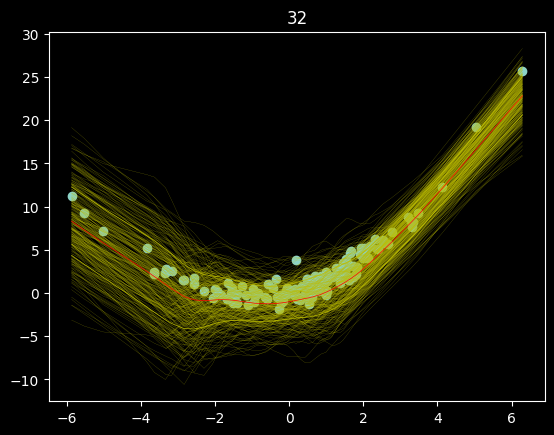

In [730]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("32")

Text(0.5, 1.0, '16')

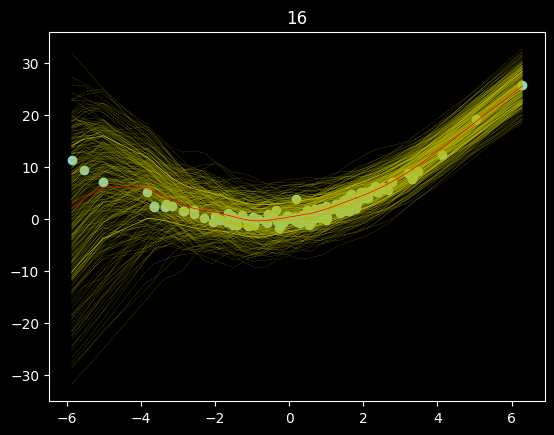

In [726]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("16")

Text(0.5, 1.0, '8')

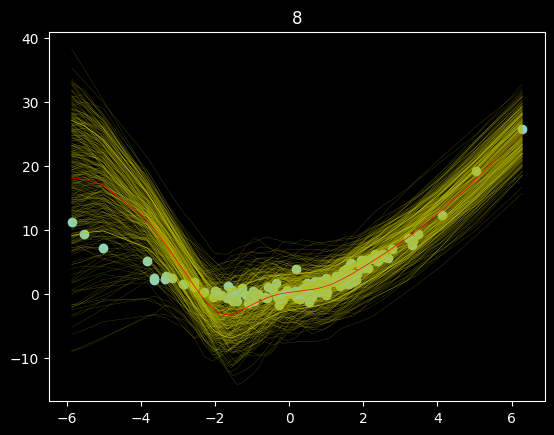

In [722]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("8")

# Monotonicity

In [772]:
ind = np.argsort(X.flatten())

In [810]:
def plot_monotonic(X, ind, opt_state, i):
    z = np.zeros((X[ind].shape[0], 15)).at[i, :].add(1)
    # o = 0.5np.ones((X[ind].shape[0], 15))
    plt.plot(X[ind], bforward((get_params(opt_state), -0.4*z + .5), X[ind]), c='red')
    plt.plot(X[ind], bforward((get_params(opt_state), -0.2*z + .5), X[ind]), c='orange')
    plt.plot(X[ind], bforward((get_params(opt_state),  0.0*z + .5), X[ind]), c='yellow')
    plt.plot(X[ind], bforward((get_params(opt_state),  0.2*z + .5), X[ind]), c='green')
    plt.plot(X[ind], bforward((get_params(opt_state),  0.4*z + .5), X[ind]), c='blue')

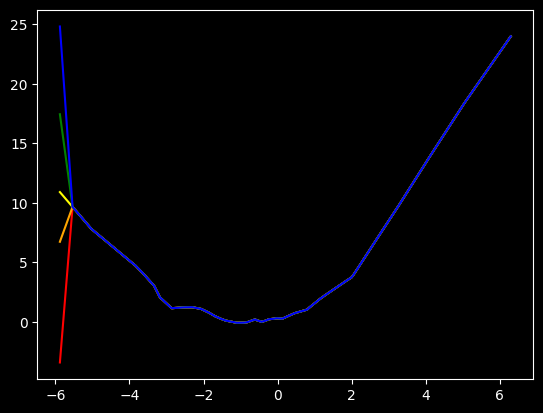

In [811]:
plot_monotonic(X, ind, opt_state, 0)

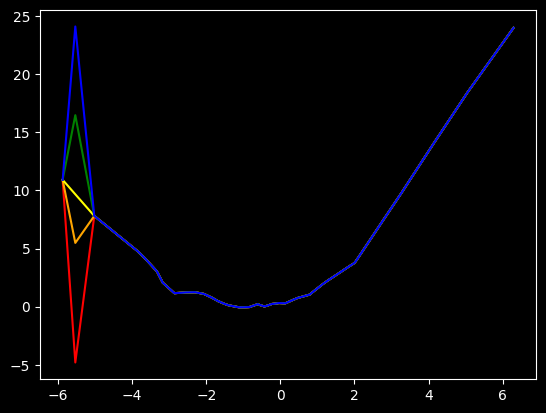

In [812]:
plot_monotonic(X, ind, opt_state, 1)

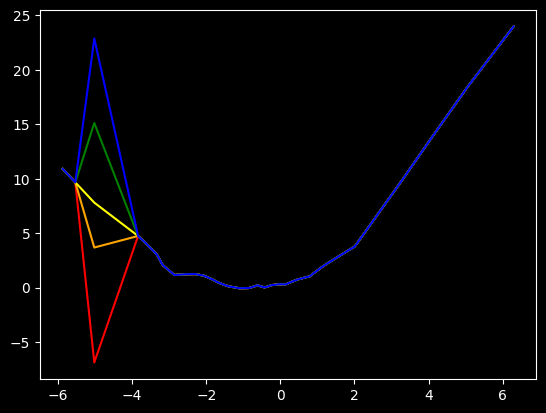

In [813]:
plot_monotonic(X, ind, opt_state, 2)

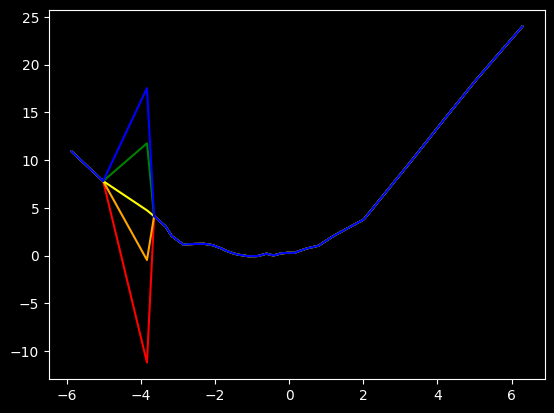

In [814]:
plot_monotonic(X, ind, opt_state, 3)

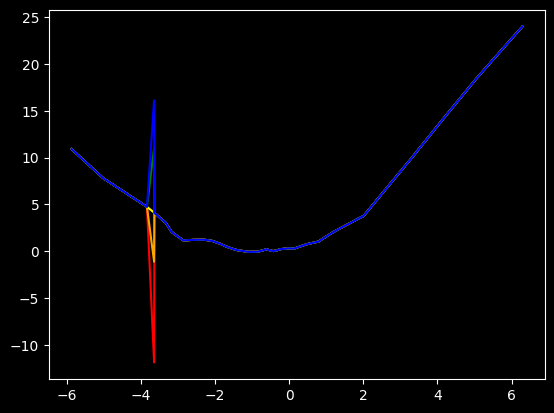

In [815]:
plot_monotonic(X, ind, opt_state, 4)

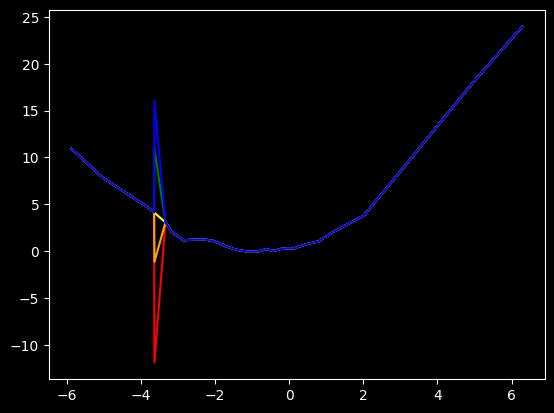

In [816]:
plot_monotonic(X, ind, opt_state, 5)

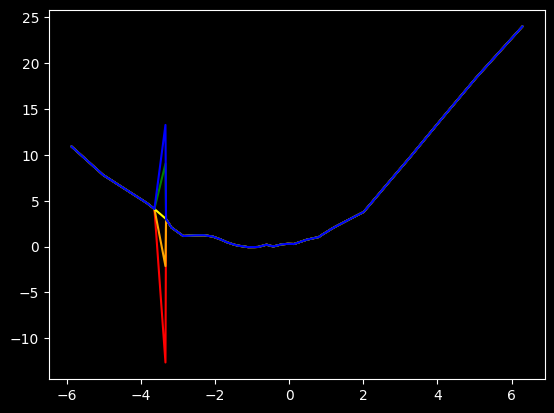

In [817]:
plot_monotonic(X, ind, opt_state, 6)

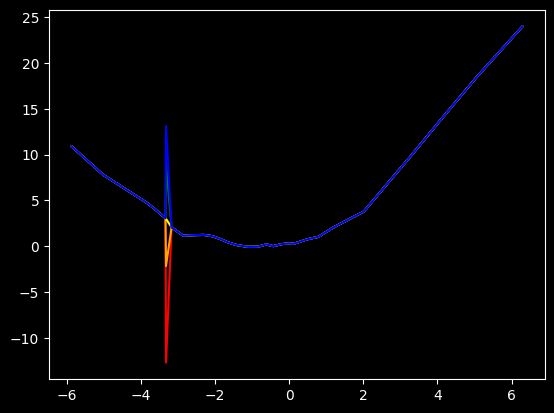

In [818]:
plot_monotonic(X, ind, opt_state, 7)

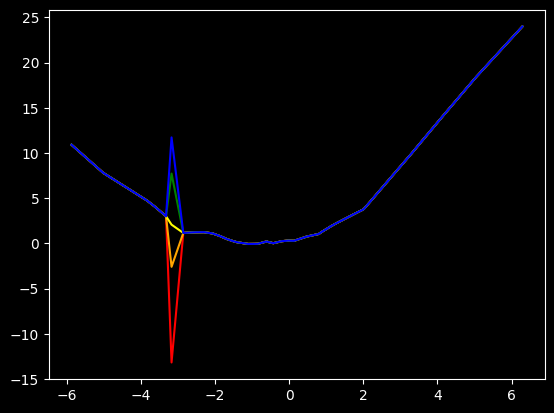

In [819]:
plot_monotonic(X, ind, opt_state, 8)

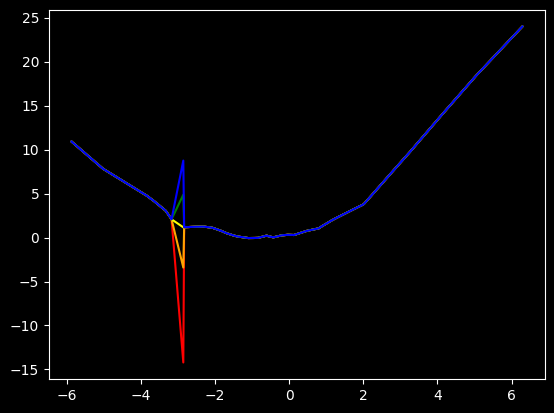

In [820]:
plot_monotonic(X, ind, opt_state, 9)

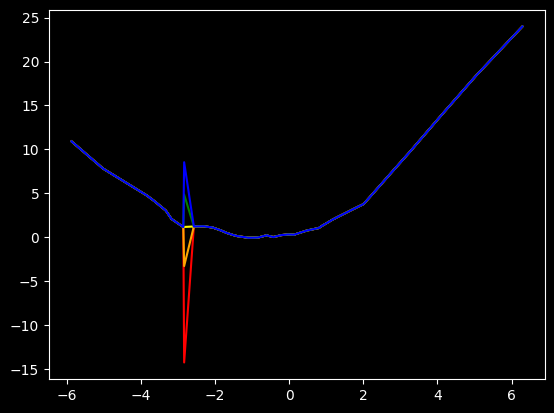

In [821]:
plot_monotonic(X, ind, opt_state, 10)

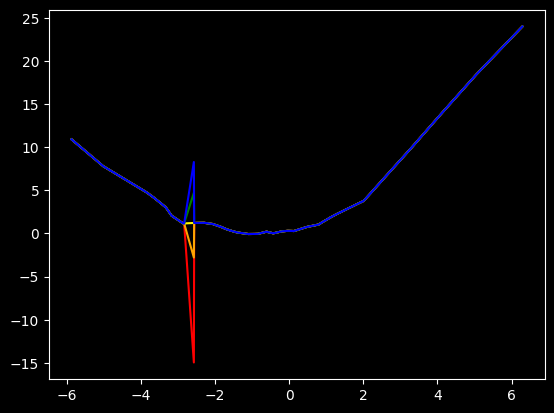

In [822]:
plot_monotonic(X, ind, opt_state, 11)

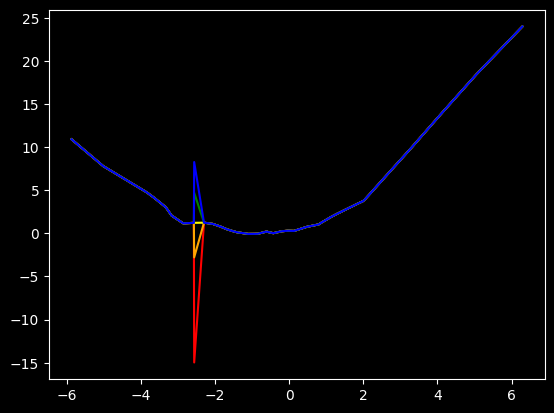

In [823]:
plot_monotonic(X, ind, opt_state, 12)

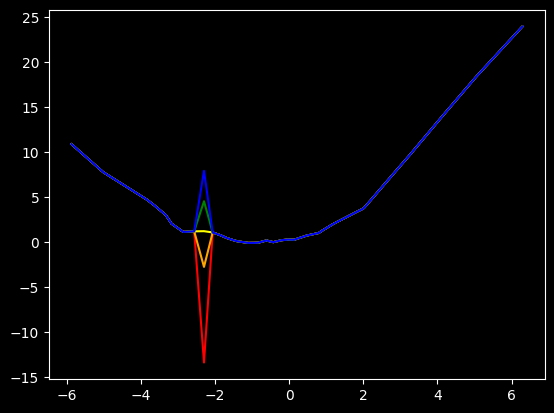

In [824]:
plot_monotonic(X, ind, opt_state, 13)

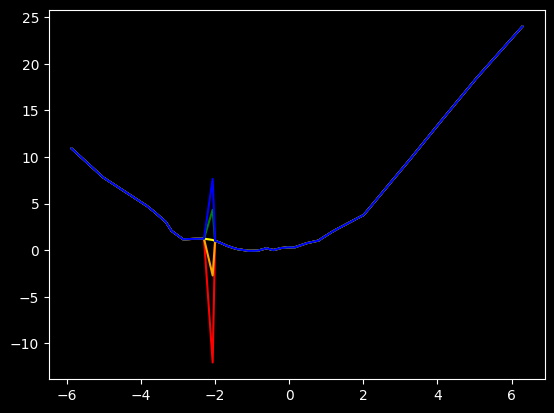

In [825]:
plot_monotonic(X, ind, opt_state, 14)

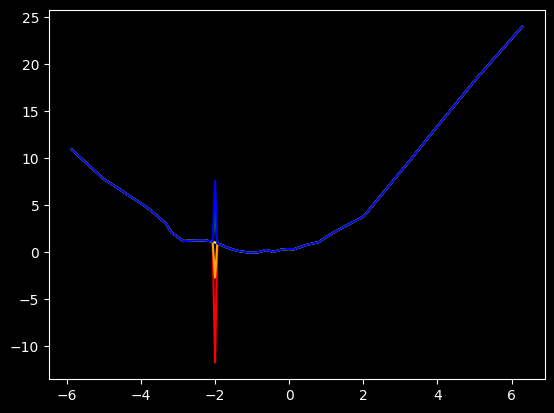

In [826]:
plot_monotonic(X, ind, opt_state, 15)

In [851]:
def plot_random(X, ind, opt_state, times):
    fig = plt.figure()
    for seed in range(times):
        z = jax.random.uniform(jax.random.PRNGKey(seed), shape=(15, )).reshape(1,-1).repeat(X[ind].shape[0], axis=0)
        # o = 0.5np.ones((X[ind].shape[0], 15))
        plt.plot(X[ind], bforward((get_params(opt_state), z), X[ind]), c='red')

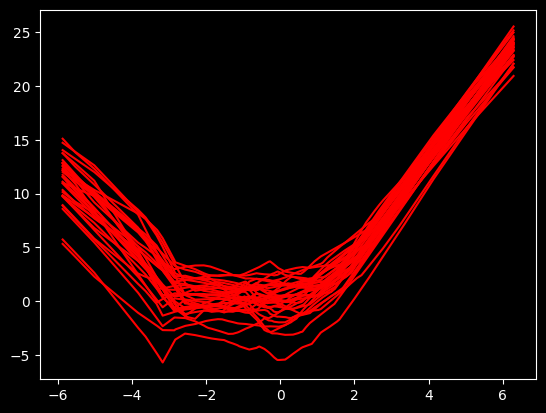

In [854]:
plot_random(X, ind, opt_state, 32)

# Discussion

The above is wrong.
* the mapping U -> f should be invertible, does not have to be monotonic
* there is a problem, since U is finite dimentional and f is infinite dimentional, not all functions have non-zero density. In fact, most of them have density equal to zero. This is because the mapping is some low dimentional surface, manifold, in highly dimentional space. 
* Having an invertible mapping $h: U \rightarrow (X \rightarrow Y)$ and $h(u) = x \rightarrow f(x, u)$, we want obtain the density in the following way ([link](https://statproofbook.github.io/P/pdf-invfct.html)):
$$p(f) = p(h^{-1}(f))\left|\frac{\text{d}\,h^{-1}(f)}{\text{d}\,f}\right| $$
if $\left|\frac{\text{d}\,h^{-1}(f)}{\text{d}\,f}\right| > 0 \;\;\; \forall_{f \in h(U)}$

This means, that we need a Jacobian determinant. This also allows us to do it for all neural networks, not only piecewise-linear, and we can sample easily from an arbitrary distribution, e.g., $N(0,I)$. The problem here is that the support of f's is low dimentional. 

Questions:
* 1. What does density mean in that scenario?
* 2. What does invertibility mean?
* 3. How to enforce invertibility?

2. Invertibility.

Let's say, our function is over predefined set of points $(x_i)$:
$$h(u) = [f(x_1, u), f(x_2, u), \cdots f(x_n, u)]$$ 
??? or maybe not. But here we can talk about invertible vector functions. 

Maybe we should enforce stronger conditions? Maybe we should make it as follows:
Given $u_1, u_2 \sim U$ we want functions $d(h(u_1), h(u_2))$ to be high. Whatever high means. This would bias the model, if I'm correct. 

Maybe the conditions already impose invertibility, as we want as much randomness of the functions as possible. But we can achieve arbitrary randomness without invertibility.

Invertibility does not make sense. We can create an invertible transformation, that is not necessarily what we would want. Something that returns two almost identical functions, yet not completly the same, and hance the transformation is invertible.

I think, that the root of the problem really, is that the transformation is from low dimentional input, to a high dimentional output. Hence not every function in the final space is achievable. Maybe we should return not the function, but firstly function expectation and standard deviation, and then sample final value from that. This would give us some distribution over all functions. If two U's would give similar expected values, the expected values would be reachable from one to another. On the other hand, this way we would be able to reach every and each function from many expected values, so the transformation could not be invertible. 


We should read how they do it in the wake-sleep model. 

* Is it even important to have invertibility? Will the solution to the optimization problem be different?
* I think, we should add make additional assumptions, that could be reachable, like monotonicity? 